In [2064]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier # 决策树
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score,train_test_split, GridSearchCV

import warnings
warnings.filterwarnings("ignore")


In [2065]:
trade_df = pd.read_csv('./trade.csv')
train_df = pd.read_csv('./user_train.csv')
test_df = pd.read_csv('./user_test.csv')

### 2.1分析、提取数据

处理trade文件，将时间属性标准化

In [2066]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

'''
# 使用 Min-Max 标准化
min_max_scaler = MinMaxScaler()
trade_df['time_normalized'] = min_max_scaler.fit_transform(trade_df[['time']])
trade_df
'''
# 使用 Z-score 标准化
z_score_scaler = StandardScaler()
trade_df['time_normalized'] = z_score_scaler.fit_transform(trade_df[['time']])


提取数据：
处理trade文件，计算每个用户的交易次数，提取出每个用户常用的ip, url, 国家，设备，经常购买的东西

In [2067]:
def trade_data_processing(trade_df):
    # 计算每个用户的交易数量
    trade_count = trade_df.groupby('bidder_id').size().reset_index(name='trade_count')
    trade_count = trade_count.reset_index(drop=True)

    #计算每个用户竞拍的平均时间
    average_times = trade_df.groupby('bidder_id')['time_normalized'].mean()
    average_times = average_times.reset_index(name='average_times')

    # 计算每个用户最常用的设备
    device_counts = trade_df.groupby(['bidder_id', 'device']).size()
    device_counts = device_counts.reset_index(name='device_counts')
    most_used_devices = device_counts.loc[device_counts.groupby('bidder_id')['device_counts'].idxmax()]
    most_used_devices = most_used_devices.rename(columns={"device": "most_used_device"}).reset_index(drop=True)

    # 计算每个用户最常在的国家
    country_counts = trade_df.groupby(['bidder_id', 'country']).size()
    country_counts = country_counts.reset_index(name='country_counts')
    most_used_countries = country_counts.loc[country_counts.groupby('bidder_id')['country_counts'].idxmax()]
    most_used_countries = most_used_countries.rename(columns={"country": "most_used_country"}).reset_index(drop=True)

    #计算每个用户最常购买的东西merchandise 
    merchandise_counts = trade_df.groupby(['bidder_id','merchandise']).size()
    merchandise_counts = merchandise_counts.reset_index(name='merchandise_counts')
    most_merchandise = merchandise_counts.loc[merchandise_counts.groupby('bidder_id')['merchandise_counts'].idxmax()]
    most_merchandise = most_merchandise.rename(columns={"merchandise":"most_merchandise"}).reset_index(drop=True)
    
    #计算每个用户最常用的ip
    ip_counts = trade_df.groupby(['bidder_id','ip']).size()
    ip_counts = ip_counts.reset_index(name='ip_counts')
    most_used_ip = ip_counts.loc[ip_counts.groupby('bidder_id')['ip_counts'].idxmax()]
    most_used_ip = most_used_ip.rename(columns={"ip":"most_used_ip"}).reset_index(drop=True)
     
    #计算每个用户最常用的url
    url_counts = trade_df.groupby(['bidder_id','url']).size()
    url_counts = url_counts.reset_index(name='url_counts')
    most_used_url = url_counts.loc[url_counts.groupby('bidder_id')['url_counts'].idxmax()]
    most_used_url = most_used_url.rename(columns={"url":"most_used_url"}).reset_index(drop=True)

    # 合并所有表格
    feature_df = trade_count.merge(most_used_devices, on='bidder_id', how='left').reset_index(drop=True)
    feature_df = feature_df.merge(most_used_countries, on='bidder_id', how='left').reset_index(drop=True)
    feature_df = feature_df.merge(average_times, on='bidder_id', how='left').reset_index(drop=True)
    feature_df = feature_df.merge(most_merchandise, on='bidder_id', how='left').reset_index(drop=True)
    feature_df = feature_df.merge(most_used_ip, on='bidder_id', how='left').reset_index(drop=True)
    feature_df = feature_df.merge(most_used_url, on='bidder_id', how='left').reset_index(drop=True)
    #feature_df = feature_df.drop(columns=['url_counts','ip_counts','country_counts','merchandise_counts','device_counts'])
    return feature_df

# 处理交易数据并生成用户特征数据框 user_feature_df
user_feature_df = trade_data_processing(trade_df)

# 将处理后的user_feature_df分别与train_df和test_df数据集合并
train_df = train_df.merge(user_feature_df, left_on='bidder_id', right_on='bidder_id', how='left')
test_df = test_df.merge(user_feature_df, left_on='bidder_id', right_on='bidder_id', how='left')

### 2.2数据预处理

2.2.1 查看并填充缺失值，（推测缺失值是未交易过的用户数据）

In [2068]:
# 查看train_df每一列的缺失值,推测缺失值是没有进行交易的用户
missing_values_per_column = train_df.isnull().sum()
missing_values_per_column

bidder_id             0
payment_account       0
address               0
outcome               0
trade_count           5
most_used_device      5
device_counts         5
most_used_country     5
country_counts        5
average_times         5
most_merchandise      5
merchandise_counts    5
most_used_ip          5
ip_counts             5
most_used_url         5
url_counts            5
dtype: int64

In [2069]:
# 查看test_df每一列的缺失值,推测缺失值是没有进行交易的用户
missing_values_per_column2 = test_df.isnull().sum()
missing_mask = test_df.isnull().any(axis=1)
missing_values_per_column2

bidder_id              0
payment_account        0
address                0
trade_count           24
most_used_device      24
device_counts         24
most_used_country     25
country_counts        25
average_times         24
most_merchandise      24
merchandise_counts    24
most_used_ip          24
ip_counts             24
most_used_url         24
url_counts            24
dtype: int64

In [2070]:
# 查找包含缺失值的行并输出标签
def print_missing_labels(df, label_col):
    missing_rows = df[df.isnull().any(axis=1)]
    if not missing_rows.empty:
        print("train_df 存在缺失值的用户的标签:")
        print(missing_rows[label_col])
    else:
        print("没有缺失值.")

# 打印训练数据集中包含缺失值的行的标签
print_missing_labels(train_df, 'outcome')

train_df 存在缺失值的用户的标签:
5      0.0
56     0.0
91     0.0
404    0.0
434    0.0
Name: outcome, dtype: float64


填充缺失值

In [2071]:

def fillNAN(df):
    # 选择数值型和布尔型数据
    num_columns = df.select_dtypes(include=["number", "bool"]).columns
    # 选择标称属性（非数值型和布尔型数据）
    cat_columns = df.select_dtypes(exclude=["number", "bool"]).columns

    # 填充数值型和布尔型数据的缺失值为平均数
    for col in num_columns:
        mean_value = df[col].mean()
        df[col] = df[col].fillna(mean_value)

    # 填充标称属性的缺失值为众数
    for col in cat_columns:
        mode_value = df[col].mode()[0]
        df[col] = df[col].fillna(mode_value)
    return df

# 填充缺失值为平均值或众数
# train_df = fillNAN(train_df)
# test_df = fillNAN(test_df)

# 填充缺失值为0
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

2.2.2 去除异常值

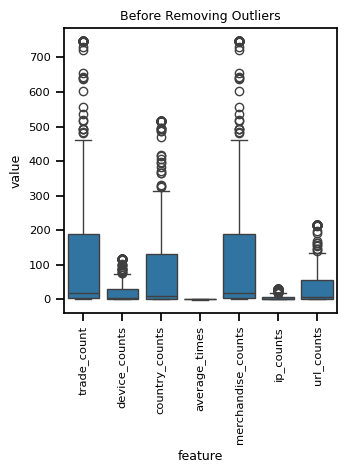

In [2072]:
# 箱线图去除异常值
def remove_outliers_box(df):
    cleaned_df = df.copy()  
    # 处理连续型特征
    continuous_features = df.drop(columns=['outcome']).select_dtypes(include=['number']).columns
    for column in continuous_features:
        # 使用箱线图计算上下边缘
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 3 * iqr
        upper = q3 + 3 * iqr
        #将异常值替换为最大值或者最小值：
        df[column] = np.where(df[column] > upper, upper, df[column])
        df[column] = np.where(df[column] < lower, lower, df[column])

    # 选择数值型列进行可视化
    numeric_columns = train_df.select_dtypes(include=[np.number]).columns.tolist()
    # 将数据转换为长格式
    train_df_melted = train_df.melt(id_vars=['outcome'], value_vars=numeric_columns, var_name='feature', value_name='value')

    # 绘制去除异常值前的箱线图
    plt.subplot(1, 2, 1)
    sns.boxplot(x='feature', y='value', data=train_df_melted)
    plt.title('Before Removing Outliers')
    plt.xticks(rotation=90)

    plt.tight_layout()
    plt.show()
    return cleaned_df
train_df = remove_outliers_box(train_df)

In [2073]:
def remove_outliers(df):
    numeric_columns = df.drop(columns=['outcome']).select_dtypes(include=[np.number]).columns
    
    for column in numeric_columns:
        mean = df[column].mean()
        std = df[column].std()
        upper_bound = mean + 3 * std
        lower_bound = mean - 3 * std
        
        # 将超出3σ范围的异常值替换为最大或最小值
        df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
        df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    
    return df

### 2.2.3相关性分析

通过卡方检验计算标称属性与outcome的相关性

In [2074]:
# 存储卡方检验结果的字典
chi2_results = {}

# 要进行卡方检验的属性
categorical_columns = ['trade_count','average_times','most_used_device', 'most_used_country', 'most_merchandise','most_used_ip','most_used_url']

# 对每个属性进行卡方检验
for column in categorical_columns:
    contingency_table = pd.crosstab(train_df[column], train_df['outcome'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi2_results[column] = p

# 将结果转换为 DataFrame 并按 p 值排序
chi2_df = pd.DataFrame(list(chi2_results.items()), columns=['Feature', 'p_value'])
chi2_df = chi2_df.sort_values(by='p_value')

# 输出P值结果
print("卡方检验结果 (按 p 值排序):")
for index, row in chi2_df.iterrows():
    print(f"{row['Feature']} 与标签的p值: {row['p_value']}")

# 判断并输出有显著相关性的特征
alpha = 0.05
significant_features = [feature for feature, p_value in chi2_results.items() if p_value < alpha]

if significant_features:
    print("\n与标签有显著相关性的标称属性有：")
    for feature in significant_features:
        print(feature)
else:
    print("\n没有标称属性与标签之间有显著的相关性。")


卡方检验结果 (按 p 值排序):
trade_count 与标签的p值: 2.4482008174724135e-16
most_used_country 与标签的p值: 1.0624510375206792e-05
most_used_url 与标签的p值: 0.07327042437444542
average_times 与标签的p值: 0.42896394693577283
most_used_ip 与标签的p值: 0.5028500783829134
most_merchandise 与标签的p值: 0.7320468589690592
most_used_device 与标签的p值: 0.9213488225184201

与标签有显著相关性的标称属性有：
trade_count
most_used_country


计算连续属性与outcome的相关性

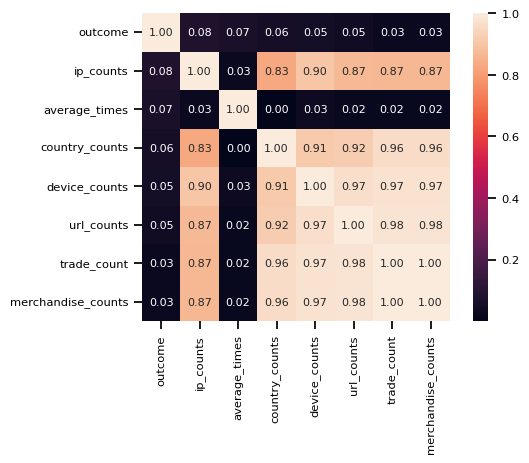

与标签 'outcome' 相关性最大的7个属性：
Index(['ip_counts', 'average_times', 'country_counts', 'device_counts',
       'url_counts', 'trade_count', 'merchandise_counts'],
      dtype='object')


In [2075]:
import seaborn as sns
import matplotlib.pyplot as plt

# 选择数值型和布尔型数据
num_features = train_df.select_dtypes(include=["number"]).copy()
# 计算相关系数矩阵
corrmat = num_features.corr()
# 选择与目标变量 'outcome' 相关性最大的7个属性
k = 7
cols = corrmat.nlargest(k + 1, 'outcome')['outcome'].index  # 加1是因为包括了目标变量本身
cm = np.corrcoef(train_df[cols].values.T)

# 画出heatmap
sns.set_context("notebook", font_scale=0.75)
plt.figure(figsize=(6, 4))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f',annot_kws={'size': 8}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

print("与标签 'outcome' 相关性最大的7个属性：")
print(cols[1:])


对标称属性进行独热编码

In [2076]:

# 合并训练集和测试集
combined_df = pd.concat([train_df, test_df], keys=['train', 'test'])

# 进行独热编码
categorical_features = ['most_used_country']
combined_encoded = pd.get_dummies(combined_df, columns=categorical_features)

# 拆分回训练集和测试集
train_encoded = combined_encoded.xs('train')
test_encoded = combined_encoded.xs('test')


生成特征交互

In [2077]:
 # 生成特征交互
def generate_feature_interactions(train_df, test_df, categorical_features):
    for feature1 in categorical_features:
        for feature2 in categorical_features:
            if feature1 != feature2:
                train_df[f'{feature1}-{feature2}'] = train_df[feature1].astype(str) + '-' + train_df[feature2].astype(str)
                test_df[f'{feature1}-{feature2}'] = test_df[feature1].astype(str) + '-' + test_df[feature2].astype(str)

    # 合并训练集和测试集
    combined_df = pd.concat([train_df, test_df], keys=['train', 'test'])

    # 独热编码
    interaction_features = [f'{feature1}-{feature2}' for feature1 in categorical_features for feature2 in categorical_features if feature1 != feature2]
    combined_encoded = pd.get_dummies(combined_df, columns=interaction_features)

    # 拆分回训练集和测试集
    train_encoded = combined_encoded.xs('train')
    test_encoded = combined_encoded.xs('test')

    return train_encoded, test_encoded

#选择特征most_used_ip和most_used_device进行交互
#选择特征most_used_device和most_used_url进行交互
categorical_features = ['most_used_ip', 'most_used_country']
train_encoded, test_encoded = generate_feature_interactions(train_df, test_df, categorical_features)
categorical_features = ['most_used_device', 'most_used_url']
train_encoded, test_encoded = generate_feature_interactions(train_encoded, test_encoded, categorical_features)

In [2078]:
# 将布尔列转换为浮点列
for column in train_encoded.columns:
    if train_encoded[column].dtype == bool:
        train_encoded[column] = train_encoded[column].astype(np.float64)
for column in test_encoded.columns:
    if test_encoded[column].dtype == bool:
        test_encoded[column] = test_encoded[column].astype(np.float64)


In [2079]:
#删去非数值属性的列用于训练
columns1 = train_encoded.select_dtypes(exclude=["number", "bool"]).columns
number_train = train_encoded.drop(columns=columns1)
number_test = test_encoded.drop(columns=columns1)
number_test = number_test.drop(columns=['outcome'])

In [2080]:
# 将number_train划分为数据集和训练集来训练模型
train_train, train_test = train_test_split(number_train, test_size=0.4, random_state=42)
Y = train_train['outcome']
X = train_train.drop(columns=['outcome']).select_dtypes(include=['number'])

RandomForest

In [2081]:
# 使用随机森林模型进行训练和交叉验证
clf1 = RandomForestClassifier(n_estimators=50, max_features=2, criterion='gini')
clf1.fit(X, Y)
scores = cross_val_score(clf1, X, Y, cv=5)
print('RF准确率：', scores.mean())

# 定义RF调优的参数网格param_grid1
param_grid1 = {
    'n_estimators': [50, 100, 150],
    'max_features': [2, 3, 4],
    'criterion': ['gini', 'entropy']
}
# 实例化 GridSearchCV 对象
grid_search1 = GridSearchCV(clf1, param_grid1, cv=5)

# 使用网格搜索对模型进行参数调优
grid_search1.fit(X, Y)

# 输出最佳参数组合和对应的评分
print("最佳参数组合: ", grid_search1.best_params_)
print("最佳准确率: ", grid_search1.best_score_)

# 使用最佳参数训练模型并进行评估
best_clf1 = grid_search1.best_estimator_
scores = cross_val_score(best_clf1, X, Y, cv=5)
print('调优后RF准确率：', scores.mean())


RF准确率： 0.9501639344262296


'\n# 定义RF调优的参数网格param_grid1\nparam_grid1 = {\n    \'n_estimators\': [50, 100, 150],\n    \'max_features\': [2, 3, 4],\n    \'criterion\': [\'gini\', \'entropy\']\n}\n# 实例化 GridSearchCV 对象\ngrid_search1 = GridSearchCV(clf1, param_grid1, cv=5)\n\n# 使用网格搜索对模型进行参数调优\ngrid_search1.fit(X, Y)\n\n# 输出最佳参数组合和对应的评分\nprint("最佳参数组合: ", grid_search1.best_params_)\nprint("最佳准确率: ", grid_search1.best_score_)\n\n# 使用最佳参数训练模型并进行评估\nbest_clf1 = grid_search1.best_estimator_\nscores = cross_val_score(best_clf1, X, Y, cv=5)\nprint(\'调优后RF准确率：\', scores.mean())\n'

AdaBoost

In [2082]:
# 初始化AdaBoost模型
clf2 = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3),n_estimators=150,learning_rate=1,algorithm='SAMME.R',)
clf2.fit(X, Y)
scores = cross_val_score(clf2, X, Y, cv=5)
print('AdaBoost准确率：', scores.mean())

# 定义要调优的参数范围
param_grid2 = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.001, 0.01, 0.1, 1],
    'estimator': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=3)],
    'algorithm': ['SAMME', 'SAMME.R']
}

# 使用网格搜索进行参数调优
grid_search2 = GridSearchCV(estimator=clf2, param_grid=param_grid2, cv=5, scoring='accuracy')
grid_search2.fit(X, Y)

# 打印最佳参数组合
print("最佳参数组合：", grid_search2.best_params_)
print("最佳准确率：", grid_search2.best_score_)

# 使用最佳参数训练模型并进行评估
best_clf2 = grid_search2.best_estimator_
scores = cross_val_score(best_clf2, X, Y, cv=5)
print('调优后AB准确率：', scores.mean())


AdaBoost准确率： 0.9535519125683061


'\n# 定义要调优的参数范围\nparam_grid2 = {\n    \'n_estimators\': [50, 100, 150, 200],\n    \'learning_rate\': [0.001, 0.01, 0.1, 1],\n    \'estimator\': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=3)],\n    \'algorithm\': [\'SAMME\', \'SAMME.R\']\n}\n\n# 使用网格搜索进行参数调优\ngrid_search2 = GridSearchCV(estimator=clf2, param_grid=param_grid2, cv=5, scoring=\'accuracy\')\ngrid_search2.fit(X, Y)\n\n# 打印最佳参数组合\nprint("最佳参数组合：", grid_search2.best_params_)\nprint("最佳准确率：", grid_search2.best_score_)\n\n# 使用最佳参数训练模型并进行评估\nbest_clf2 = grid_search2.best_estimator_\nscores = cross_val_score(best_clf2, X, Y, cv=5)\nprint(\'调优后AB准确率：\', scores.mean())\n'

Bagging

In [2083]:
# 初始化Bagging模型
clf3 = BaggingClassifier(n_estimators=20,max_features=0.7,max_samples=0.7)
clf3.fit(X, Y)
scores = cross_val_score(clf3, X, Y, cv=5)
print('Bagging准确率：', scores.mean())

# 定义参数网格
param_grid3 = {
    'n_estimators': [10, 20, 50, 100],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False]
}
# 使用 GridSearchCV 进行参数调优
grid_search3 = GridSearchCV(estimator=clf3, param_grid=param_grid3, cv=5, scoring='accuracy', n_jobs=-1)
grid_search3.fit(X, Y)

# 打印最佳参数组合
print("最佳参数组合：", grid_search3.best_params_)
print("最佳准确率：", grid_search3.best_score_)

# 使用最佳参数训练模型并进行评估
best_clf3 = grid_search3.best_estimator_
scores = cross_val_score(best_clf3, X, Y, cv=5)
print('调优后Bagging准确率：', scores.mean())


Bagging准确率： 0.9534972677595629


'\n# 定义参数网格\nparam_grid3 = {\n    \'n_estimators\': [10, 20, 50, 100],\n    \'max_samples\': [0.5, 0.7, 1.0],\n    \'max_features\': [0.5, 0.7, 1.0],\n    \'bootstrap\': [True, False],\n    \'bootstrap_features\': [True, False]\n}\n# 使用 GridSearchCV 进行参数调优\ngrid_search3 = GridSearchCV(estimator=clf3, param_grid=param_grid3, cv=5, scoring=\'accuracy\', n_jobs=-1)\ngrid_search3.fit(X, Y)\n\n# 打印最佳参数组合\nprint("最佳参数组合：", grid_search3.best_params_)\nprint("最佳准确率：", grid_search3.best_score_)\n\n# 使用最佳参数训练模型并进行评估\nbest_clf3 = grid_search3.best_estimator_\nscores = cross_val_score(best_clf3, X, Y, cv=5)\nprint(\'调优后Bagging准确率：\', scores.mean())\n'

测试集预测模型计算AUC

In [2084]:

y_real = train_test['outcome']
X_test = train_test.drop(columns=['outcome']).select_dtypes(include=["number", "bool"])

# 预测结果
y_pred1 = clf1.predict_proba(X_test)[:, 1]
y_pred2 = clf2.predict_proba(X_test)[:, 1]
y_pred3 = clf3.predict_proba(X_test)[:, 1]

# 计算AUC
auc1 = roc_auc_score(y_real, y_pred1)
print("RF Valid aUC: ", auc1)
auc2 = roc_auc_score(y_real, y_pred2)
print("AdaBoost Valid aUC: ", auc2)
auc3 = roc_auc_score(y_real, y_pred3)
print("Bagging Valid aUC: ", auc3)


RF Valid aUC:  0.7989035087719298
AdaBoost Valid aUC:  0.7484649122807017
Bagging Valid aUC:  0.6712719298245614


用训练好的模型预测test_df数据集，并保存结果

In [2085]:
Y1 = number_train['outcome']
X1 = number_train.drop(columns=['outcome']).select_dtypes(include=['number'])
clf1.fit(X1,Y1)

# 预测test_df数据集
X_test = number_test.select_dtypes(include=["number", "bool"])
y_test = clf1.predict_proba(X_test)[:, 1]

# 保存预测结果
test_df['prediction'] = y_test
test_df[['prediction']].to_csv('result.csv', index=False, header=False)